# Assignment 3 - CS3920

In [74]:
from sklearn.datasets import load_wine
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.svm import SVC
from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.preprocessing import StandardScaler, MinMaxScaler, Normalizer, RobustScaler
from sklearn.base import BaseEstimator
import matplotlib.pyplot as plt

import numpy as np

- Global constants

In [75]:
CV: int = 3
RANDOM_STATE: int = 3103

# Useful Functions

## Convert Dictionary to String

- Takes a dictionary and creates a nice string representation 
- Each key and value are printed with consistent spacing between them

In [76]:
def dictionary_to_string(dictionary: dict) -> str:
	"""Creates a formatted string from a dictionary.

	Args:
		dictionary (dict): dictionary to be formatted

	Returns:
		str: formatted string
	"""	
	# Get the keys and values from the dictionary
	keys: list[str] = list(dictionary.keys())
	values: list[float, dict] = list(dictionary.values())

	# Get the column widths
	column_widths: list[int] = [
		max([len(str(key)), len(str(value))])
		for key, value in zip(keys, values)
	]

	# Create the formatted rows
	formatted_rows: list[str] = []
	for key, value in zip(keys, values):
		# Create a list of formatted column values
		formatted_columns: list[str] = [
			f"{key:{column_widths[0]}}\t {value:{column_widths[1]}}"
		]
		# Join the formatted columns into a single string
		formatted_row: str = " | ".join(formatted_columns)
		formatted_rows.append(formatted_row)

	# Join the formatted rows into a single string
	formatted_table = "\n".join(formatted_rows)
	return formatted_table		

# Loading Datasets

**Question 1**

## Loading Wine Dataset

In [77]:
wine: np.ndarray = load_wine()
X_wine: np.ndarray = wine.data
y_wine: np.ndarray = wine.target

## Loading USPS Dataset

In [78]:
DATA_SPLIT: int = 10 # percentage of data to be used 

In [79]:
zip_train: np.ndarray = np.genfromtxt('zip.train', delimiter=' ')
zip_train = zip_train[::DATA_SPLIT]

zip_test: np.ndarray = np.genfromtxt('zip.test', delimiter=' ')
zip_test = zip_test[::DATA_SPLIT]

zip_data: np.ndarray = np.concatenate((zip_train, zip_test), axis=0)
zip_data = zip_data[::DATA_SPLIT]

X_zip: np.ndarray = zip_data[:, 1:]
y_zip: np.ndarray = zip_data[:, 0]

In [80]:
del zip_train, zip_test

# Splitting Datasets 

**Question 2**

- This functions splits the dataset into training set and test set for each matrix of features `X` and labels  `y`
- It takes the features `X` and labels `y` and returns the split data

In [81]:
def split(X: np.ndarray, y: np.ndarray) -> tuple[np.ndarray[float]]:
	"""Splits the dataset into training and testing sets.

	Args:
		X (np.ndarray): matrix of features
		y (np.ndarray): labels 

	Returns:
		tuple[np.ndarray[float]]: X and y training and testing sets (4 in total)
	"""	
	return train_test_split(X, y, test_size=0.3, random_state=RANDOM_STATE)
	

## Splitting Wine Dataset

In [82]:
X_wine_train, X_wine_test, y_wine_train, y_wine_test = split(X_wine, y_wine)

## Splitting USPS Dataset

In [83]:
X_zip_train, X_zip_test, y_zip_train, y_zip_test = split(X_zip, y_zip)

# Cross Validation

In [84]:
class Cross_Validation:
	def __init__ (self, X_train: np.ndarray, y_train: np.ndarray, X_test: np.ndarray, y_test: np.ndarray):
		self.X_train = X_train
		self.y_train = y_train
		self.X_test = X_test
		self.y_test = y_test
		self.svm: SVC = SVC()
		self.svm.fit(self.X_train, self.y_train)

	def scores_list(self) -> float:
		return cross_val_score(self.svm, self.X_train, self.y_train, cv=CV)

	@property
	def score(self) -> float:
		scores: np.ndarray = cross_val_score(self.svm, self.X_train, self.y_train, cv=CV)
		return (self.scores_list()).mean()

	@property
	def error_rate(self) -> float:
		return (1 - self.score)

	@property
	def test_score(self) -> float:
		return self.svm.score(self.X_test, self.y_test)

	@property
	def test_error_rate(self) -> float:
		return (1 - self.test_score)

	def __str__(self) -> str:
		data: dict = {
			"Score": self.score,
			"Error Rate": self.error_rate,
			"Test Score": self.test_score,
			"Test Error Rate": self.test_error_rate
		}
		return dictionary_to_string(data)	

**Question 3 and 4**

3. `Score` = Estimation of accuracy parameter
4. `Test Error Rate` = Test error rate of the SVM

## Cross Validate Wine

In [85]:
wine_cross_validation: Cross_Validation = Cross_Validation(X_wine_train, y_wine_train, X_wine_test, y_wine_test)
print(wine_cross_validation)

Score             	 0.6533101045296168
Error Rate        	 0.3466898954703832
Test Score        	 0.7222222222222222
Test Error Rate   	 0.2777777777777778


## Cross Validate USPS

In [86]:
zip_cross_validation: Cross_Validation = Cross_Validation(X_zip_train, y_zip_train, X_zip_test, y_zip_test)
print(zip_cross_validation)

Score            	 0.660894660894661
Error Rate       	 0.339105339105339
Test Score       	 0.5517241379310345
Test Error Rate  	 0.4482758620689655


# Pipeline

**Question 5**

## Dictionary of Hyperparameters

- Dictionary containing a grid of hyperparameters to be used in a grid search.
- The grid contains two hyperparameters: 
  - `C` (`svc__C`) - determines the strength of regularization, or the penalty applied to the model for making incorrect predictions
    - Larger gamma value means that the model is more non-linear, resulting in a more complex and potentially overfitting model
    - Smaller gamma value means that the model is more linear, resulting in a simpler and potentially underfitting model
  - `gamma` (`svc__gamma`) - determines the strength of the non-linearity of the model
    - Larger gamma value means that the model is more non-linear, resulting in a more complex and potentially overfitting model
    - Smaller gamma value means that the model is more linear, resulting in a simpler and potentially underfitting model

In [87]:
param_grid: dict[str, list[float]] = {
	'svc__C': [0.001, 0.01, 0.1, 1, 10, 100], 
	'svc__gamma': [0.001, 0.01, 0.1, 1, 10, 100]
}

- Creates a pipeline with Support Vector Correlation (SVC) and some specified scaler (normalizer)
- It takes the training and test data
- Uses Grid Search and Cross-Validation to tune parameters `C` and `gamma`

## Algorithm

- Creates a model that uses a support vector machine (SVM) classifier with a scaler and performs a grid search
- Uses a pipeline to chain the scaler and the `SVM` classifier
- There are several methods:
  - `best_score` - Computes the score of the predictions made on the test set
    - Can be used to compare the performance of different models or to choose the final model to use for making predictions on new data
  - `best_params` - Identifies the set of hyperparameters that produce the best performance.
    - Can be used to choose the final model to use for making predictions on new data
  - `test_score` - Computes the score of the predictions made on the test set
    - It applies the trained model to the test data and returns a score that indicates how well the model is able to make predictions on the test data
    - Can then be used to choose the final model to use for making predictions on new data
  - `error_rate` - Computes the error rate of the predictions made on the test set
    - $1-score$
    - Hence the points about `test_score` still apply

In [88]:
class Super_Pipeline:
	"""Creates a model that uses a support vector machine (SVM) classifier with a scaler and performs a grid search. 
	Uses a pipeline to chain the scaler and the `SVM` classifier.
	"""	
	def __init__ (self, param_grid: dict[str, list[float]], scaler: BaseEstimator, X_train: np.ndarray[float], y_train: np.ndarray[float], X_test: np.ndarray[float], y_test: np.ndarray[float]):	
		self.pipeline: Pipeline = make_pipeline(scaler(), SVC())
		self.grid: GridSearchCV = GridSearchCV(self.pipeline, param_grid, cv=CV)
		self.grid.fit(X_train, y_train)
		self.X_train: np.ndarray[float] = X_train
		self.y_train: np.ndarray[float] = y_train
		self.X_test: np.ndarray[float] = X_test
		self.y_test: np.ndarray[float] = y_test
		
	@property
	def best_score(self) -> float:
		"""Computes the score that was obtained using the best set of hyperparameters. 

		Returns:
			float: best score
		"""		
		return self.grid.best_score_

	@property
	def best_params(self) -> dict[str, float]:
		"""Identifies the set of hyperparameters that produce the best performance. 

		Returns:
			dict[str, float]: best parameters
		"""		
		return self.grid.best_params_

	@property
	def test_score(self) -> float:
		"""Computes the score of the predictions made on the test set.


		Returns:
			float: score of the predictions made on the test set
		"""		
		return self.grid.score(self.X_test, self.y_test)

	@property
	def error_rate(self) -> float:
		"""Computes the error rate of the predictions made on the test set.

		Returns:
			float: error rate of the predictions made on the test set
		"""		
		return (1 - self.best_score)

	def __str__(self) -> str:
		"""Returns a string representation of the object.
		- Best cross-validation score
		- Best parameters
		- Test set score
		- Test Set Error Rate

		Returns:
			str: string representation of the object
		"""	
		data: dict = {
			"Best Cross-Validation Score": f"{self.best_score}",
			"Best Parameters": f"{self.best_params}",
			"Test Set Score": f"{self.test_score}",
			"Test Set Error Rate": f"{self.error_rate}"
		}
		return dictionary_to_string(data)

## Wine Dataset

### MinMax Scaler

In [89]:
wine_super_pipe_minmax: Super_Pipeline = Super_Pipeline(param_grid, MinMaxScaler, X_wine_train, y_wine_train, X_wine_test, y_wine_test)
print(wine_super_pipe_minmax)

Best Cross-Validation Score	 0.991869918699187                
Best Parameters            	 {'svc__C': 10, 'svc__gamma': 0.1}
Test Set Score             	 0.9814814814814815               
Test Set Error Rate        	 0.008130081300813052             


### Standard Scaler

In [90]:
wine_super_pipe_standard: Super_Pipeline = Super_Pipeline(param_grid, StandardScaler, X_wine_train, y_wine_train, X_wine_test, y_wine_test)
print(wine_super_pipe_standard)

Best Cross-Validation Score	 0.983933410762679                   
Best Parameters            	 {'svc__C': 100, 'svc__gamma': 0.001}
Test Set Score             	 0.9814814814814815                  
Test Set Error Rate        	 0.01606658923732096                 


### Normalizer

In [91]:
wine_super_pipe_normalizer: Super_Pipeline = Super_Pipeline(param_grid, Normalizer, X_wine_train, y_wine_train, X_wine_test, y_wine_test)
print(wine_super_pipe_normalizer)

Best Cross-Validation Score	 0.927022841656988                 
Best Parameters            	 {'svc__C': 100, 'svc__gamma': 100}
Test Set Score             	 0.9629629629629629                
Test Set Error Rate        	 0.072977158343012                 


### Robust Scaler

In [92]:
wine_super_pipe_robust: Super_Pipeline = Super_Pipeline(param_grid, RobustScaler, X_wine_train, y_wine_train, X_wine_test, y_wine_test)
print(wine_super_pipe_robust)

Best Cross-Validation Score	 0.983739837398374                 
Best Parameters            	 {'svc__C': 10, 'svc__gamma': 0.01}
Test Set Score             	 0.9814814814814815                
Test Set Error Rate        	 0.016260162601625994              


### Comparison

In [93]:
class Graph_Comparisons:
	def __init__ (self, super_pipes: dict[str, Super_Pipeline], best_params: dict[str, float]):
		self.super_pipes: dict[str, Super_Pipeline] = super_pipes
		self.best_params: dict[str, float] = best_params

	def cross_validation_score(self, lower_bound: float, upper_bound: float) -> None:
		scores: dict = {key: pipe.best_score for key, pipe in self.super_pipes.items()}
		print(dictionary_to_string(scores))

		plt.bar(self.super_pipes.keys(), [pipe.best_score for pipe in self.super_pipes.values()])
		plt.ylabel("Cross-Validation Accuracy")
		plt.xlabel("Scaler")
		plt.ylim(lower_bound, upper_bound)
		plt.show()

	def test_score(self, lower_bound: float, upper_bound: float) -> None:
		error_rates: dict[str, float] = {key: pipe.error_rate for key, pipe in self.super_pipes.items()}
		print(dictionary_to_string(error_rates))

		plt.bar(error_rates.keys(), error_rates.values())
		plt.ylabel("Test Set Error Rate")
		plt.xlabel("Scaler")
		plt.ylim(lower_bound, upper_bound)
		plt.show()

	def best_parameter_C(self) -> None:
		best_C: dict[str, float] = {key: pipe.best_params['svc__C'] for key, pipe in self.super_pipes.items()}
		print(dictionary_to_string(best_C))

		plt.bar(self.super_pipes.keys(), [pipe.best_params['svc__C'] for pipe in self.super_pipes.values()])
		plt.bar(self.super_pipes.keys(), [pipe.best_params['svc__C'] for pipe in self.super_pipes.values()])
		plt.ylabel("Best Parameter C")
		plt.xlabel("Scaler")
		plt.show()

	def best_parameter_gamma(self) -> None:
		best_gamma: dict[str, float] = {key: pipe.best_params['svc__gamma'] for key, pipe in self.super_pipes.items()}
		print(dictionary_to_string(best_gamma))

		plt.loglog(self.super_pipes.keys(), [pipe.best_params['svc__gamma'] for pipe in self.super_pipes.values()])
		plt.ylabel("Best Parameter Gamma")
		plt.xlabel("Scaler")
		plt.xscale("log")
		plt.show()

#### Best Cross-Validation Score

In [94]:
wine_super_pipes: dict[str, Super_Pipeline] = {
	"MinMaxScaler": wine_super_pipe_minmax,
	"StandardScaler": wine_super_pipe_standard,
	"Normalizer": wine_super_pipe_normalizer,
	"RobustScaler": wine_super_pipe_robust
}
wine_graph: Graph_Comparisons = Graph_Comparisons(wine_super_pipes, param_grid)

MinMaxScaler     	 0.991869918699187
StandardScaler   	 0.983933410762679
Normalizer       	 0.927022841656988
RobustScaler     	 0.983739837398374


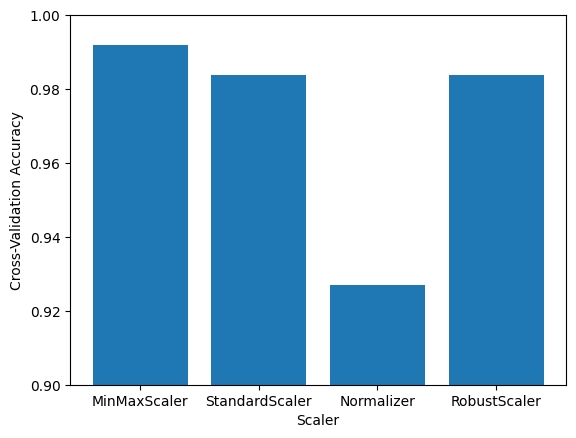

In [95]:
wine_graph.cross_validation_score(0.9, 1.0)

#### Best Parameters

MinMaxScaler	             10
StandardScaler	            100
Normalizer  	            100
RobustScaler	             10


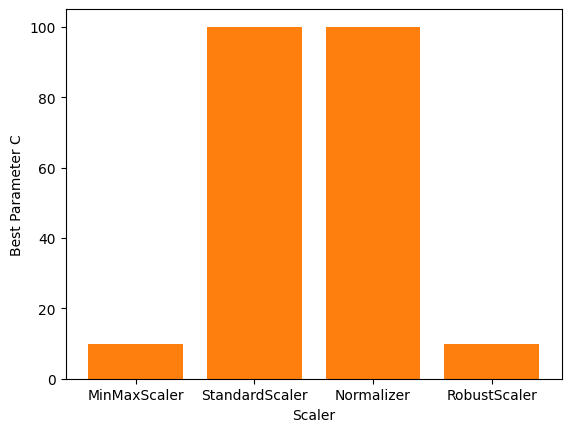

In [96]:
wine_graph.best_parameter_C()

MinMaxScaler	            0.1
StandardScaler	          0.001
Normalizer  	            100
RobustScaler	           0.01


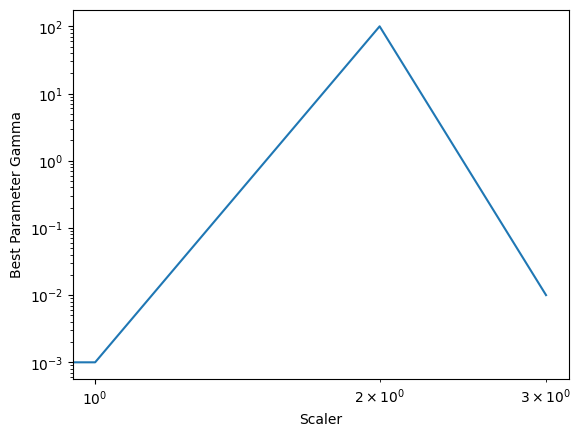

In [97]:
wine_graph.best_parameter_gamma()

#### Test Set Score

MinMaxScaler        	 0.008130081300813052
StandardScaler      	 0.01606658923732096
Normalizer          	   0.072977158343012
RobustScaler        	 0.016260162601625994


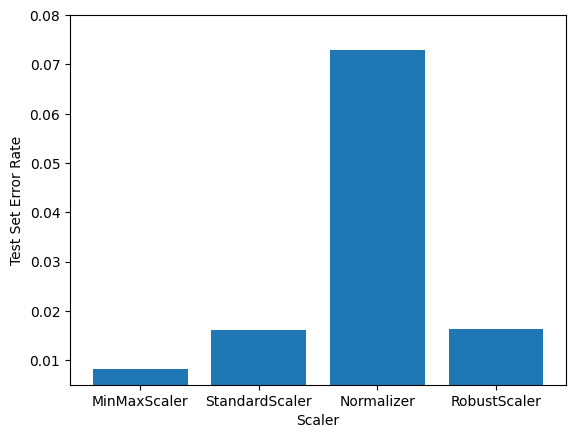

In [98]:
wine_graph.test_score(0.005, 0.08)

## USPS Dataset

### MinMax Scaler

In [99]:
zip_super_pipe_minmax: Super_Pipeline = Super_Pipeline(param_grid, MinMaxScaler, X_zip_train, y_zip_train, X_zip_test, y_zip_test)
print(zip_super_pipe_minmax)

Best Cross-Validation Score	 0.7373737373737373                  
Best Parameters            	 {'svc__C': 100, 'svc__gamma': 0.001}
Test Set Score             	 0.5862068965517241                  
Test Set Error Rate        	 0.26262626262626265                 


### Standard Scaler

In [100]:
zip_super_pipe_standard: Super_Pipeline = Super_Pipeline(param_grid, StandardScaler, X_zip_train, y_zip_train, X_zip_test, y_zip_test)
print(zip_super_pipe_standard)

Best Cross-Validation Score	 0.7070707070707071                 
Best Parameters            	 {'svc__C': 10, 'svc__gamma': 0.001}
Test Set Score             	 0.5517241379310345                 
Test Set Error Rate        	 0.29292929292929293                


### Normalizer

In [101]:
zip_super_pipe_robust: Super_Pipeline = Super_Pipeline(param_grid, RobustScaler, X_zip_train, y_zip_train, X_zip_test, y_zip_test)
print(zip_super_pipe_robust)

Best Cross-Validation Score	 0.4437229437229437                  
Best Parameters            	 {'svc__C': 100, 'svc__gamma': 0.001}
Test Set Score             	 0.5862068965517241                  
Test Set Error Rate        	 0.5562770562770563                  


### Robust Scaler

In [102]:
zip_super_pipe_normalizer: Super_Pipeline = Super_Pipeline(param_grid, Normalizer, X_zip_train, y_zip_train, X_zip_test, y_zip_test)
print(zip_super_pipe_normalizer)

Best Cross-Validation Score	 0.7532467532467533                
Best Parameters            	 {'svc__C': 100, 'svc__gamma': 0.1}
Test Set Score             	 0.5862068965517241                
Test Set Error Rate        	 0.24675324675324672               


### Comparison

#### Best Cross-Validation Score

In [117]:
zip_super_pipes: dict[str, Super_Pipeline] = {
	"MinMaxScaler": zip_super_pipe_minmax,
	"StandardScaler": zip_super_pipe_standard,
	"Normalizer": zip_super_pipe_normalizer,
	"RobustScaler": zip_super_pipe_robust
}

zip_graph: Graph_Comparisons = Graph_Comparisons(zip_super_pipes, param_grid)

MinMaxScaler      	 0.7373737373737373
StandardScaler    	 0.7070707070707071
Normalizer        	 0.7532467532467533
RobustScaler      	 0.4437229437229437


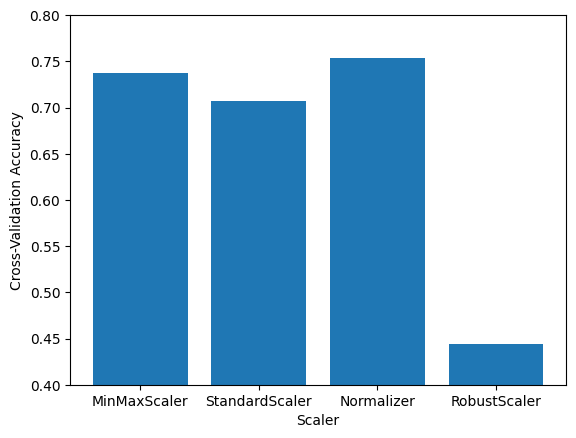

In [118]:
zip_graph.cross_validation_score(0.4, 0.8)

#### Best Parameters

MinMaxScaler	            100
StandardScaler	             10
Normalizer  	            100
RobustScaler	            100


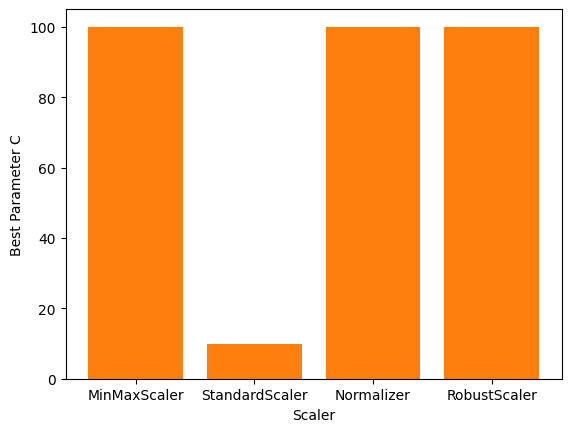

In [119]:
zip_graph.best_parameter_C()

MinMaxScaler	            100
StandardScaler	             10
Normalizer  	            100
RobustScaler	            100


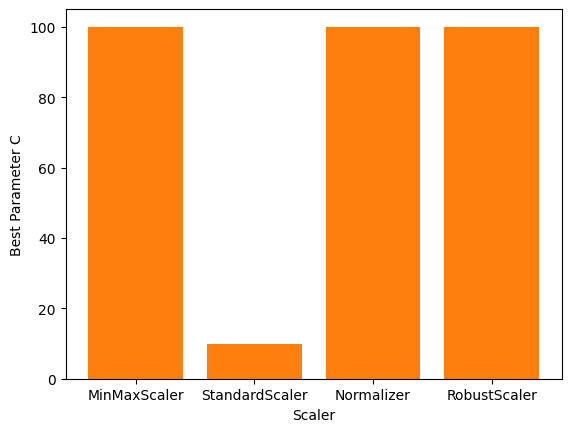

In [120]:
zip_graph.best_parameter_C()

#### Test Set Score

MinMaxScaler       	 0.26262626262626265
StandardScaler     	 0.29292929292929293
Normalizer         	 0.24675324675324672
RobustScaler       	  0.5562770562770563


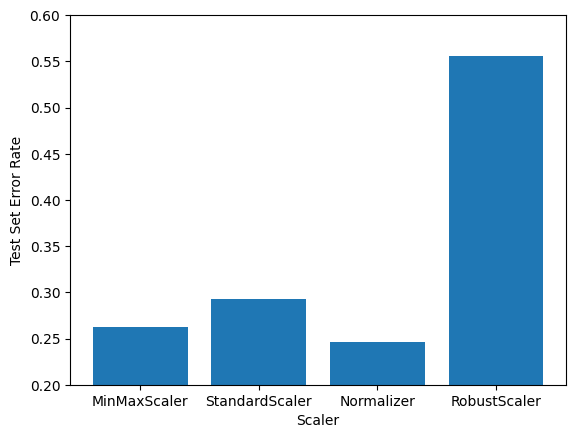

In [121]:
zip_graph.test_score(0.2, 0.6)

# 6 - Predict Test Labels

## Wine Dataset

### MinMax Scaler

In [107]:
print("Test Set Score: ", wine_super_pipe_minmax.test_score)

Test Set Score:  0.9814814814814815


### Standard Scaler

In [108]:
print("Test Set Score: ", wine_super_pipe_standard.test_score)

Test Set Score:  0.9814814814814815


### Normalizer

In [109]:
print("Test Set Score: ", wine_super_pipe_normalizer.test_score)

Test Set Score:  0.9629629629629629


### Robust Scalar

In [110]:
print("Test Set Score: ", wine_super_pipe_robust.test_score)

Test Set Score:  0.9814814814814815


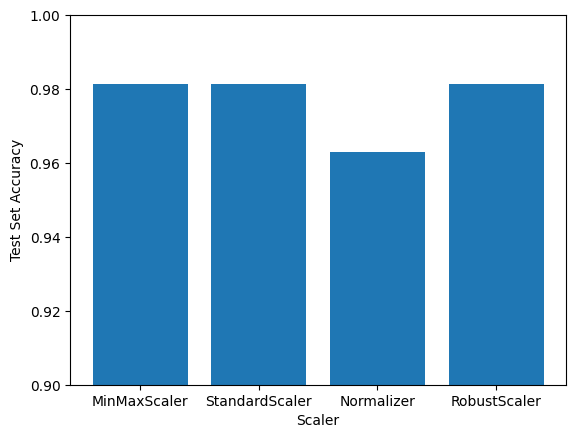

In [111]:
plt.bar(wine_super_pipes.keys(), [pipe.test_score for pipe in wine_super_pipes.values()])
plt.ylabel("Test Set Accuracy")
plt.xlabel("Scaler")
plt.ylim(0.9, 1.0)
plt.show()

## Zip Dataset

### MinMax Scaler

In [112]:
print("Test Set Score: ", zip_super_pipe_standard.test_score)

Test Set Score:  0.5517241379310345


### Standard Scaler

In [113]:
print("Test Set Score: ", zip_super_pipe_standard.test_score)

Test Set Score:  0.5517241379310345


### Normalizer

In [114]:
print("Test Set Score: ", zip_super_pipe_normalizer.test_score)

Test Set Score:  0.5862068965517241


### Robust Scaler

In [115]:
print("Test Set Score: ", zip_super_pipe_robust.test_score)

Test Set Score:  0.5862068965517241


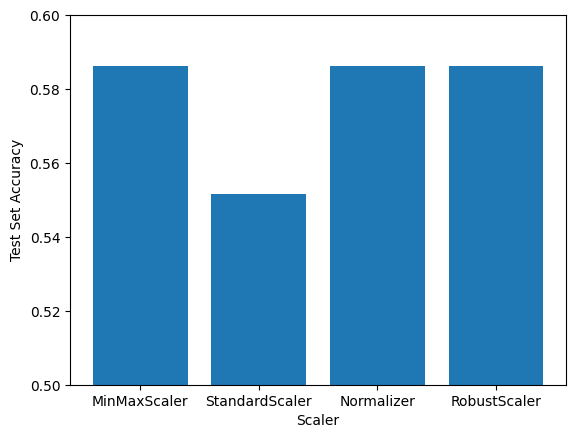

In [116]:
plt.bar(zip_super_pipes.keys(), [pipe.test_score for pipe in zip_super_pipes.values()])
plt.ylabel("Test Set Accuracy")
plt.xlabel("Scaler")
plt.ylim(0.5, 0.6)
plt.show()

# 7 - Cross-Conformal Prediction